In [1]:
%load_ext autoreload
%autoreload 2

In [51]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import urllib.request
import pickle
mpl.rcParams['figure.dpi']= 150


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
import numpy as np
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

plt.style.use('ggplot')

import ipywidgets as widgets
from ipywidgets import interact, fixed


# Data
'''#from transat.data import HYPOTHETICAL_SUBMISSION_DATE
from transat.data.load import download_historical, load_historical
from transat.data.split import split_historical
from transat.data.transform import preprocess_historical_basic, dataframe_to_array'''

# Metric
from transat.metric import mae

# Scenario/Simulation
from transat.data.scenario import generate_scenario

In [4]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
'''url_pop = 'https://github.com/transatlantic-team/Pandemic-Prize/blob/visualization/transat/data/assets/geoid_population_regions.csv'
file_pop = '/data/geoid_population_regions.csv'

def download_pop(url=url_pop, file=file_pop):
    if not os.path.exists('data'):
        os.mkdir('data')
    urllib.request.urlretrieve(url, file) 
    
def load_population(file=file_pop):
    # Load historical data from local file
    df = pd.read_csv(file,
        parse_dates=['Date'],
        encoding="ISO-8859-1",
        dtype={"GeoID": str,
               "Population": int64},
        error_bad_lines=False)
    return df'''

'url_pop = \'https://github.com/transatlantic-team/Pandemic-Prize/blob/visualization/transat/data/assets/geoid_population_regions.csv\'\nfile_pop = \'/data/geoid_population_regions.csv\'\n\ndef download_pop(url=url_pop, file=file_pop):\n    if not os.path.exists(\'data\'):\n        os.mkdir(\'data\')\n    urllib.request.urlretrieve(url, file) \n    \ndef load_population(file=file_pop):\n    # Load historical data from local file\n    df = pd.read_csv(file,\n        parse_dates=[\'Date\'],\n        encoding="ISO-8859-1",\n        dtype={"GeoID": str,\n               "Population": int64},\n        error_bad_lines=False)\n    return df'

In [6]:
HYPOTHETICAL_SUBMISSION_DATE = np.datetime64("2020-09-30")

In [37]:
df = pd.read_csv('df_dataframe_preprocessed.csv')

In [7]:
# Main source for the training data
DATA_URL = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
# Local file
DATA_FILE = 'data/OxCGRT_latest.csv'


def download_historical(url=DATA_URL, file=DATA_FILE):
    """Download data located at 'url' and save them at location 'file'
    >>> from transat.data.load import download_historical
    >>> download_historical()
    """
    if not os.path.exists('data'):
        os.mkdir('data')
    urllib.request.urlretrieve(url, file)

def load_historical(file=DATA_FILE):
    """Load historical data located at 'file'
    >>> from transat.data.load import load_historical
    >>> df = load_historical()
    """
    # Load historical data from local file
    df = pd.read_csv(file,
        parse_dates=['Date'],
        encoding="ISO-8859-1",
        dtype={"RegionName": str,
               "RegionCode": str},
        error_bad_lines=False)
    return df

In [8]:
download_historical()
df = load_historical()

In [9]:
'''download_pop()
pop = load_population()'''

'download_pop()\npop = load_population()'

In [10]:
df.rename(columns=lambda x: x.replace(' ','_').replace('/','_'), inplace=True)

In [11]:
#Assignate the correct type
df.Date = pd.to_datetime(df['Date'], format='%Y%m%d')
df = df.astype({'C1_School_closing':'category', 'C2_Workplace_closing':'category', 
           'C3_Cancel_public_events':'category','C4_Restrictions_on_gatherings':'category',
           'C5_Close_public_transport':'category', 'C6_Stay_at_home_requirements':'category', 
           'C7_Restrictions_on_internal_movement':'category', 'C8_International_travel_controls':'category', 
           'E1_Income_support':'category', 'E2_Debt_contract_relief':'category', 
           'H1_Public_information_campaigns':'category', 'H2_Testing_policy':'category', 
           'H3_Contact_tracing':'category',  'CountryCode':'category',
           'H6_Facial_Coverings':'category', 'H7_Vaccination_policy':'category', 'M1_Wildcard':'category'})

In [12]:
#Jurisdiction, M1 and all the indexes can be dropped
df.drop(['Jurisdiction','M1_Wildcard', 'StringencyIndex', 'StringencyIndexForDisplay', 'StringencyLegacyIndex', 
        'StringencyLegacyIndexForDisplay', 'GovernmentResponseIndex', 'GovernmentResponseIndexForDisplay',
        'ContainmentHealthIndex', 'ContainmentHealthIndexForDisplay', 'EconomicSupportIndex', 
        'EconomicSupportIndexForDisplay', 'C1_Flag', 'C2_Flag', 'C3_Flag', 'C4_Flag', 'C5_Flag', 
        'C6_Flag', 'C7_Flag', 'E1_Flag', 'H1_Flag', 'H6_Flag', 'H7_Flag'], axis=1, inplace=True)

In [13]:
#Create feature for CountryName and Region
df['CountryRegion'] = df.RegionName
df.CountryRegion = df.CountryRegion.fillna(df.CountryName)

In [14]:
#Delete USA, UK only country data
indexes = list(df[((df.CountryRegion=='United States') | (df.CountryRegion=='United Kingdom'))].index)

#Delete Brazil and Canada regions
indexes.extend(df[((df.CountryName=='Brazil') & (df.RegionName.isna()==False))].index)
indexes.extend(df[((df.CountryName=='Canada') & (df.RegionName.isna()==False))].index)

#Delete Turkmenistan, Tonga and Malta
indexes.extend(df[((df.CountryName=='Tonga') | (df.CountryName=='Turkmenistan')) | (df.CountryName=='Malta')].index)

df.drop(labels = indexes, axis=0, inplace=True)

In [15]:
#Create new variables for day, month and year
df['Month'] = df.Date.apply(lambda x: x.month)
df['Year'] = df.Date.apply(lambda x: x.year)
df['Day'] = df.Date.apply(lambda x: x.day)

In [16]:
#Initialized values to 0 in categorical variables to then fill na with the previous value
df.loc[(df['Date']=='2020-01-01'), 'C1_School_closing'] = 0
df.loc[(df['Date']=='2020-01-01'), 'C2_Workplace_closing'] = 0
df.loc[(df['Date']=='2020-01-01'), 'C3_Cancel_public_events'] = 0
df.loc[(df['Date']=='2020-01-01'), 'C4_Restrictions_on_gatherings'] = 0
df.loc[(df['Date']=='2020-01-01'), 'C5_Close_public_transport'] = 0
df.loc[(df['Date']=='2020-01-01'), 'C6_Stay_at_home_requirements'] = 0
df.loc[(df['Date']=='2020-01-01'), 'C7_Restrictions_on_internal_movement'] = 0
df.loc[(df['Date']=='2020-01-01'), 'C8_International_travel_controls'] = 0
df.loc[(df['Date']=='2020-01-01'), 'E1_Income_support'] = 0
df.loc[(df['Date']=='2020-01-01'), 'E2_Debt_contract_relief'] = 0
df.loc[(df['Date']=='2020-01-01'), 'H1_Public_information_campaigns'] = 0
df.loc[(df['Date']=='2020-01-01'), 'H2_Testing_policy'] = 0
df.loc[(df['Date']=='2020-01-01'), 'H3_Contact_tracing'] = 0
df.loc[(df['Date']=='2020-01-01'), 'H6_Facial_Coverings'] = 0
df.loc[(df['Date']=='2020-01-01'), 'H7_Vaccination_policy'] = 0

In [17]:
#Fill NaN values by 0
df.C1_School_closing.fillna(method='ffill', inplace=True)
df.C2_Workplace_closing.fillna(method='ffill', inplace=True)
df.C3_Cancel_public_events.fillna(method='ffill', inplace=True)
df.C4_Restrictions_on_gatherings.fillna(method='ffill', inplace=True)
df.C5_Close_public_transport.fillna(method='ffill', inplace=True)
df.C6_Stay_at_home_requirements.fillna(method='ffill', inplace=True)
df.C7_Restrictions_on_internal_movement.fillna(method='ffill', inplace=True)
df.C8_International_travel_controls.fillna(method='ffill', inplace=True)
df.E1_Income_support.fillna(method='ffill', inplace=True)
df.E2_Debt_contract_relief.fillna(method='ffill', inplace=True)
df.E3_Fiscal_measures.fillna(0, inplace=True)
df.E4_International_support.fillna(0, inplace=True)
df.H1_Public_information_campaigns.fillna(method='ffill', inplace=True)
df.H2_Testing_policy.fillna(method='ffill', inplace=True)
df.H3_Contact_tracing.fillna(method='ffill', inplace=True)
df.H4_Emergency_investment_in_healthcare.fillna(0, inplace=True)
df.H5_Investment_in_vaccines.fillna(0, inplace=True)
df.H6_Facial_Coverings.fillna(method='ffill', inplace=True)
df.H7_Vaccination_policy.fillna(method='ffill', inplace=True)

In [18]:
#Confirmed cases fill na with previous values
df.loc[(df['Date']=='2020-01-01'), 'ConfirmedCases'] = 0
df.ConfirmedCases.fillna(method='ffill', inplace=True)

In [19]:
#Confirmed deaths fill na with previous values
df.loc[(df['Date']=='2020-01-01'), 'ConfirmedDeaths'] = 0
df.ConfirmedDeaths.fillna(method='ffill', inplace=True)

In [20]:
df.columns

Index(['CountryName', 'CountryCode', 'RegionName', 'RegionCode', 'Date',
       'C1_School_closing', 'C2_Workplace_closing', 'C3_Cancel_public_events',
       'C4_Restrictions_on_gatherings', 'C5_Close_public_transport',
       'C6_Stay_at_home_requirements', 'C7_Restrictions_on_internal_movement',
       'C8_International_travel_controls', 'E1_Income_support',
       'E2_Debt_contract_relief', 'E3_Fiscal_measures',
       'E4_International_support', 'H1_Public_information_campaigns',
       'H2_Testing_policy', 'H3_Contact_tracing',
       'H4_Emergency_investment_in_healthcare', 'H5_Investment_in_vaccines',
       'H6_Facial_Coverings', 'H7_Vaccination_policy', 'ConfirmedCases',
       'ConfirmedDeaths', 'CountryRegion', 'Month', 'Year', 'Day'],
      dtype='object')

In [21]:
#Create Cateorical variable to countries. from 1 to 182.
df['CountryCodeCat'] = df.CountryCode.cat.codes

In [22]:
#Number of nan
for col in df.columns:
    print(col, df[col].isnull().sum())

CountryName 0
CountryCode 0
RegionName 63724
RegionCode 63724
Date 0
C1_School_closing 0
C2_Workplace_closing 0
C3_Cancel_public_events 0
C4_Restrictions_on_gatherings 0
C5_Close_public_transport 0
C6_Stay_at_home_requirements 0
C7_Restrictions_on_internal_movement 0
C8_International_travel_controls 0
E1_Income_support 0
E2_Debt_contract_relief 0
E3_Fiscal_measures 0
E4_International_support 0
H1_Public_information_campaigns 0
H2_Testing_policy 0
H3_Contact_tracing 0
H4_Emergency_investment_in_healthcare 0
H5_Investment_in_vaccines 0
H6_Facial_Coverings 0
H7_Vaccination_policy 0
ConfirmedCases 0
ConfirmedDeaths 0
CountryRegion 0
Month 0
Year 0
Day 0
CountryCodeCat 0


# Spain Model

In [23]:
def split_historical(df, split_date):
    """Split the historical dataframe in a training and testing datasets according to a 'split_date'.
    >>> from transat.data import HYPOTHETICAL_SUBMISSION_DATE
    >>> from transat.data.split import split_historical
    >>> df_train, df_test = split_historical(df, HYPOTHETICAL_SUBMISSION_DATE)
    Args:
        df (pd.DataFrame): the dataframe to split.
        split_date (np.datetime64): the split date.
    Returns:
        (df_train, df_test): where ``df_train`` contains all data <= ``split_date`` and ``df_test`` contains all data > ``split_date``.
    """
    df_train = df[df.Date <= split_date]
    df_test = df[df.Date > split_date]
    return df_train, df_test

In [24]:
print("Spliting at : ", HYPOTHETICAL_SUBMISSION_DATE)
df_train, df_test = split_historical(df, HYPOTHETICAL_SUBMISSION_DATE)

Spliting at :  2020-09-30


In [25]:
X_train = df_train.drop(['ConfirmedCases', 'Date', 'CountryName', 'CountryCode', 'RegionName', 'RegionCode',
                         'CountryRegion','E1_Income_support', 'E2_Debt_contract_relief', 'E3_Fiscal_measures',
                         'E4_International_support','H4_Emergency_investment_in_healthcare', 
                         'H5_Investment_in_vaccines','H7_Vaccination_policy', 'ConfirmedDeaths'], axis=1)
y_train = df_train.ConfirmedCases 
X_test = df_test.drop(['ConfirmedCases', 'Date', 'CountryName', 'CountryCode', 'RegionName', 'RegionCode',
                         'CountryRegion','E1_Income_support', 'E2_Debt_contract_relief', 'E3_Fiscal_measures',
                         'E4_International_support','H4_Emergency_investment_in_healthcare', 
                         'H5_Investment_in_vaccines','H7_Vaccination_policy', 'ConfirmedDeaths'], axis=1)
y_test = df_test.ConfirmedCases 

ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=300)
ada.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=4),
                  n_estimators=300)

In [26]:
with open('ada_boost.pkl', 'wb') as model_file:
            pickle.dump(ada, model_file)

In [27]:
with open('ada_boost.pkl', 'rb') as model_file:
            ada_pickle = pickle.load(model_file)

In [28]:
# Predict
y_ada = ada_pickle.predict(X_test)

In [29]:
def mae(pred, true):
        """
            Compute Mean Average Error between predictions and groundtruth
        """
        return np.mean(np.abs(pred - true))

In [30]:
mae(y_ada, y_test)

229739.6130363415

In [35]:
df_predicted = pd.DataFrame(df_test[['CountryName', 'RegionName', 'Date']])

In [37]:
df_predicted['PredictedDailyNewCases'] = y_ada

In [38]:
df_predicted

,CountryName,RegionName,Date,PredictedDailyNewCases
274,Aruba,NaN,2020-10-01,45256.247554
275,Aruba,NaN,2020-10-02,45256.247554
276,Aruba,NaN,2020-10-03,45256.247554
277,Aruba,NaN,2020-10-04,45256.247554
278,Aruba,NaN,2020-10-05,45256.247554
...,...,...,...,...
99675,Zimbabwe,NaN,2020-12-17,45256.247554
99676,Zimbabwe,NaN,2020-12-18,45256.247554
99677,Zimbabwe,NaN,2020-12-19,45256.247554
99678,Zimbabwe,NaN,2020-12-20,45256.247554


In [9]:
df = preprocess_historical_basic(df)

In [10]:
which_columns = df.columns

for col_name in which_columns:
    if df[col_name].isnull().values.any():
        print(f"'{col_name}' has NaN")

'RegionName' has NaN


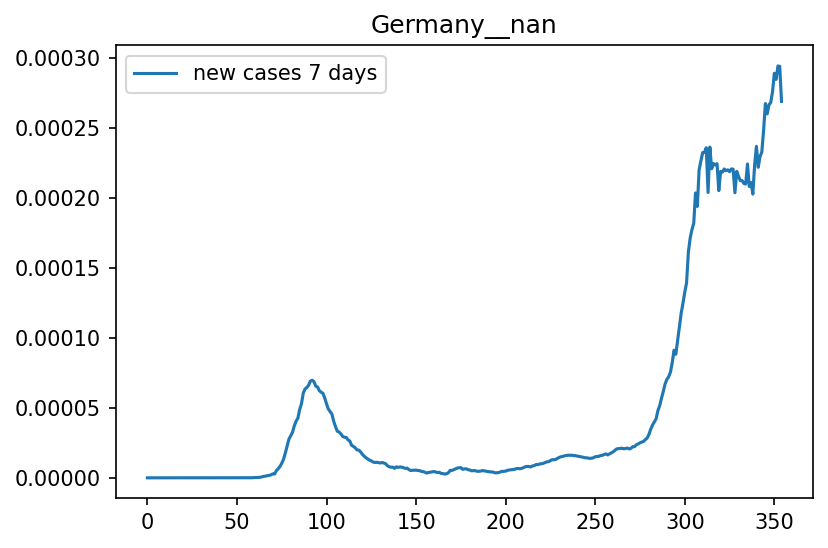

In [11]:
plt.figure()
geo_id = "Germany__nan"

plt.title(geo_id)

nc = df[df.GeoID == geo_id].NewCases.tolist()
nc7days = df[df.GeoID == geo_id].NewCasesSmoothed7Days.tolist()

# plt.plot(nc, label="new cases")
plt.plot(nc7days, label="new cases 7 days")
plt.legend()
plt.show()

In [13]:
nb_lookback_days = 30
nb_lookahead_days = 7
sequence_format = True
neg_npis = False

(X_train, y_train), (X_cols, y_col) = dataframe_to_array(df_train, nb_lookback_days=nb_lookback_days, 
    nb_lookahead_days=nb_lookahead_days, sequence_format=sequence_format, neg_npis=neg_npis)
(X_test, y_test), _ = dataframe_to_array(df_test, nb_lookback_days=nb_lookback_days,
    nb_lookahead_days=nb_lookahead_days, sequence_format=sequence_format, neg_npis=neg_npis)

# X_train, y_train = X_train.reshape(X_train.shape[0], -1), y_train.reshape(-1)
# X_test, y_test = X_test.reshape(X_test.shape[0], -1), y_test.reshape(-1)

print("X_train shape: ", np.shape(X_train))
print("y_train shape: ", np.shape(y_train))
print()
print("X_test  shape: ", np.shape(X_test))
print("y_test  shape: ", np.shape(y_test))

X_train shape:  (55932, 30, 13)
y_train shape:  (55932, 7, 1)

X_test  shape:  (10191, 30, 13)
y_test  shape:  (10191, 7, 1)


In [14]:
class LSTM:
        
    def fit(self, X, y, X_valid, y_valid, epochs=1, batch_size=32):
        
        # Build Model
        if not(hasattr(self, "model")):
            input_shape = X.shape[1:]
            self.model = self.build_model(input_shape)
            
        # Pre-process data
        self.fit_preprocess(X, y)
        X, y = self.transform(X, y)
        X_valid, y_valid = self.transform(X_valid, y_valid)
        
        # callbacks
        
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.8, patience=5, verbose=1,
            mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
        )
        
        # Fit Model
        history = self.model.fit(X, y, 
            epochs=epochs, 
            batch_size=batch_size,
            validation_data=(X_valid, y_valid),
            callbacks=[reduce_lr],
            shuffle=True,
        )
        
        return history
        
    def predict(self, X):
        X = self.transform(X)
        
        y = self.model.predict(X).reshape(-1)
        print("predict: ", y)
        
        # Inverse preprocessing
#         y = y * self.std[0] + self.mean[0]
        y = y * (self.max[0] - self.min[0]) + self.min[0]
        print("predict: ", y)
        
        return y
    
    def fit_preprocess(self, X, y):
        # MinMax (x - min) / (max - min)
        self.min = X.reshape(-1, X.shape[-1]).min(axis=0)
        self.max = X.reshape(-1, X.shape[-1]).max(axis=0)

        # Normalization
#         self.mean = X.reshape(-1, X.shape[-1]).mean(axis=0)
#         self.std = X.reshape(-1, X.shape[-1]).std(axis=0)

        
    
    
    def transform(self, X, y=None):
        X = (X - self.min) / (self.max - self.min)
#         X = (X - self.mean) / self.std
        if y is not None:
            y = (y - self.min[0]) / (self.max[0] - self.min[0])
#             y = (y - self.mean[0]) / self.std[0]
            return X, y
        else:
            return X
    
    def build_model(self, input_shape):

        input = tf.keras.Input(shape=input_shape, name='input')
#         x = tf.keras.layers.Conv1D(32, 3, activation='relu')(input)
#         x = tf.keras.layers.Conv1D(16, 3, activation='relu')(x)
#         x = tf.keras.layers.Flatten()(input)
        x = tf.keras.layers.LSTM(32, return_sequences=False)(input)
#         x = tf.keras.layers.LSTM(32, return_sequences=False)(x)
#         x = tf.keras.layers.GRU(128)(input)
#         x = tf.keras.layers.Dense(64, activation='relu')(x)
#         x = tf.keras.layers.Dense(64, activation='sigmoid', kernel_constraint=tf.keras.constraints.UnitNorm(axis=0))(x)
#         x = tf.keras.layers.Dense(32, activation='sigmoid', kernel_constraint=tf.keras.constraints.UnitNorm(axis=0))(x)
#         x = tf.keras.layers.Dense(16, activation='sigmoid', kernel_constraint=tf.keras.constraints.UnitNorm(axis=0))(x)
#         x = tf.keras.layers.Dense(32, activation='relu')(x)
#         x = tf.keras.layers.Dense(32, activation='relu')(x)
#         x = tf.keras.layers.Dense(32, activation='relu')(x)
        output = tf.keras.layers.Dense(7, activation=None, name='output')(x)
        model = tf.keras.Model(inputs=[input], outputs=[output])

        model.compile(
#             loss=tf.losses.MeanSquaredError(),
            loss=tf.keras.losses.MeanAbsoluteError(),
#             loss=tf.keras.losses.LogCosh(),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=[tf.metrics.MeanAbsoluteError()]
        )

        return model
    
model = LSTM()

In [15]:
hist = model.fit(X_train, y_train, X_test, y_test, epochs=1).history

UnknownError:  [_Derived_]  Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[model/lstm/StatefulPartitionedCall]] [Op:__inference_train_function_3009]

Function call stack:
train_function -> train_function -> train_function


NameError: name 'hist' is not defined

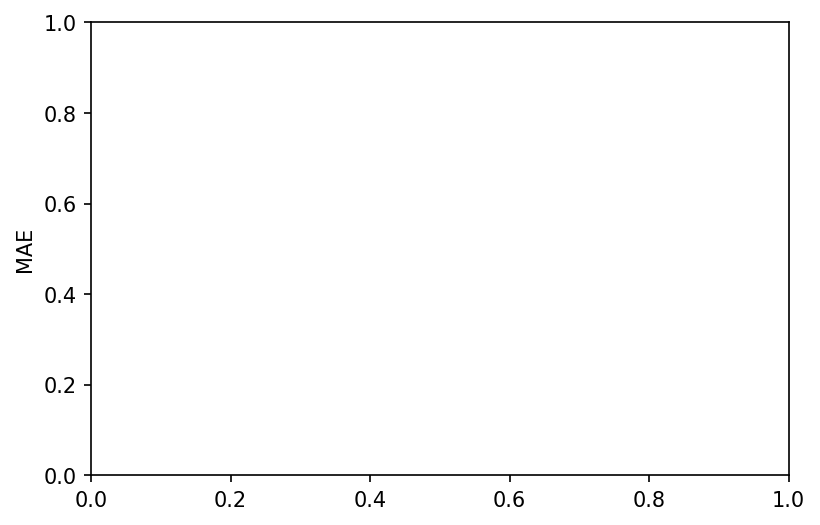

In [16]:
plt.figure()

plt.ylabel("MAE")
plt.plot(hist["mean_absolute_error"], label="mae")
plt.plot(hist["val_mean_absolute_error"], label="val_mae")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate model
# train_preds = model.predict(X_train)
# train_preds = np.maximum(train_preds, 0) # Don't predict negative cases
# print('Train MAE:', mae(train_preds, y_train))

# valid_preds = model.predict(X_valid)
# valid_preds = np.maximum(valid_preds, 0) # Don't predict negative cases
# print('Valid MAE:', mae(valid_preds, y_valid))

test_preds = model.predict(X_test)
test_preds = np.maximum(test_preds, 0) # Don't predict negative cases

print('Test MAE:', mae(test_preds, y_test.reshape(-1)))

In [ ]:
mean_variation = X_test[:,:,0].mean(axis=1)
variation_threshold = 100
test_preds[mean_variation < variation_threshold] = mean_variation[mean_variation < variation_threshold]
print('Test MAE:', mae(test_preds, y_test.reshape(-1)))

In [ ]:
model.model.save_weights("weights.h5")

In [ ]:
model.model.load_weights("weights.h5")

In [ ]:
def simulate_scenario(model, X_scenario, y_scenario, seq=False):
    # Simulate scenario

    X_sim = X_scenario.copy()
    X_sim_cases = X_sim[:,:,:1]
    X_sim_npis = X_sim[:,:,1:]
    y_sim = np.zeros(np.shape(y_scenario))

    nb_lookback_days = X_sim.shape[1]

    for d in range(y_sim.shape[1]):
        
        if seq:
            y = model.predict(X_sim)
        else:
            y = model.predict(X_sim.reshape(1,-1))
        y_sim[0,d,0] = max(y[0], 0)

        # Assuming constant NPIs here
        X_sim_npis = np.concatenate([X_sim_npis[:,1:], X_sim_npis[:,-1:]], axis=1)
        X_sim_cases = np.concatenate([X_sim_cases[:,1:], y.reshape(-1, 1, 1)], axis=1)

        X_sim =  np.concatenate([X_sim_cases, X_sim_npis], axis=-1)
        X_sim = np.array(X_sim)
    
    return y_sim

In [ ]:
# def simulate_scenario(model, X_scenario, y_scenario, seq=False):
#     # Simulate scenario

#     X_sim = X_scenario.copy()
#     X_sim_cases = X_sim[:,:,:1]
#     X_sim_npis = X_sim[:,:,1:]
#     y_sim = np.zeros(np.shape(y_scenario))

#     nb_lookback_days = X_sim.shape[1]
    
#     y_sim = model.predict(X_sim)
    
#     return y_sim

In [ ]:
def viz_scenario(geo_id, X_scenario, y_scenario, y_sim):
    mae_error = mae(y_scenario, y_sim)

    plt.figure()
    plt.title(geo_id)

    plot_input_x = np.arange(X_scenario.shape[1])
    plot_input_y = X_scenario[:,:,:1].reshape(-1)

    plt.plot(plot_input_x, plot_input_y, label="Input Scenario")

    plot_output_x = np.arange(y_scenario.shape[1])+X_scenario.shape[1]
    plot_output_x = np.concatenate([plot_input_x[-1:], plot_output_x])
    plot_output_y = np.concatenate([plot_input_y[-1:], y_scenario.reshape(-1)])
    plt.plot(plot_output_x, plot_output_y, label="Output Scenario")


    plot_output_y = np.concatenate([plot_input_y[-1:], y_sim.reshape(-1)])
    plt.plot(plot_output_x, plot_output_y, label="Output Simulation")

    plt.ylabel("New Cases")
    plt.xlabel("Days")
    ax = plt.gca()
    plt.text(0.3, 0.5, f"$MAE={mae_error:.2f}$", transform=ax.transAxes)
    plt.legend()
    plt.show()

In [ ]:
def interactive_scenario(geo_id, model, seq=True):
    nb_future_days=21

    X_scenario , y_scenario = generate_scenario(df_train, df_test, geo_id, nb_lookback_days=nb_lookback_days,
        nb_future_days=nb_future_days, sequence_format=sequence_format)
    y_sim = simulate_scenario(model, X_scenario, y_scenario, seq=seq)
    
    mean_variation = X_scenario[:,:,0].reshape(-1).mean()
    print(mean_variation)
    print(X_scenario[:,:,0].reshape(-1))
    print(y_sim.reshape(-1))
    variation_threshold = 1
    if mean_variation < variation_threshold:
        y_sim[:] = mean_variation
    viz_scenario(geo_id, X_scenario, y_scenario, y_sim)
    
geo_ids = sorted(df.GeoID.unique())

w_geo_id = widgets.Dropdown(
    options=geo_ids,
    value='France__nan',
    description='GeoID:',
    disabled=False
)

interact(interactive_scenario, geo_id=w_geo_id, model=fixed(model), seq=fixed(True))

In [17]:
model.min[0]

0.0

In [18]:
model.max[0]

0.000851649649419974